In [123]:
import os
import re
import pandas as pd
import numpy as np
import nltk
import math
import string
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score

In [124]:
frankenstein_txt = (
    open("frankenstein.txt", "r")
    .read()
    .split('Letter 1')[1]
    .split('in darkness and distance.')[0]
    .replace('\n',' ')
    .replace("  "," ")
    .strip() # remove empty lines of extra whitespace
    )
tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()

frankenstein_sentences = (
    [t.split(' ') \
        for t in tokenizer.tokenize(frankenstein_txt) \
            if len(t.split(' ')) > 10])
data = {
    'left context': [], 
    'right context':[], 
    'predicted word':[]
}

In [125]:
def clean_words(word):
    return word.translate(str.maketrans('', '', string.punctuation))

frankenstein_words = ''
for sentence in frankenstein_sentences :
    for i in range(5):
        windows = sentence[i : i+5]
        if len(windows) > 4:
            frankenstein_words += clean_words(' '.join(windows)) + ' '
            data['left context'].append(clean_words(' '.join(windows[0:2])))
            data['right context'].append(clean_words(' '.join(windows[3:5])))
            data['predicted word'].append(clean_words(windows[2]))

frankenstein_dataframe = pd.DataFrame(data=data)
frankenstein_dataframe = frankenstein_dataframe.sample(frac=1).reset_index(drop=True)
frankenstein_words = set(frankenstein_words.split(' '))
list(frankenstein_words)[:10]

['',
 'bottom',
 'uncle',
 'render',
 'shuddering',
 'motions',
 'beauties',
 'heartrending',
 'persuaded',
 'Geneva']

In [126]:
# Split the corpus
training_percentage = int(70*len(frankenstein_dataframe)/100)
validation_percentage = training_percentage + int(15*len(frankenstein_dataframe)/100)
for i, row in frankenstein_dataframe.iterrows():
    if i < training_percentage :
        frankenstein_dataframe.at[i,'corpus'] = 'train'
    elif i > training_percentage and i < validation_percentage :
        frankenstein_dataframe.at[i,'corpus'] = 'validation'
    else :
        frankenstein_dataframe.at[i,'corpus'] = 'test'
frankenstein_dataframe.iloc[:10]

,left context,right context,predicted word,corpus
0,being I,not again,dared,train
1,hour in,state of,this,train
2,degree recalled,to life,me,train
3,lead them,to danger,unwillingly,train
4,you really,this my,say,train
5,did not,me to,move,train
6,would tear,to pieces,me,train
7,relieve thee,creator he,my,train
8,quickly and,lost it,I,train
9,time I,whether I,considered,train


In [127]:
class FrankensteinDataset(Dataset):
    
    # Build the FrankensteinDataset Class
    def __init__(self, frankenstein, words):
        self.words_index  = list(words)
        self.corpus = {
            'train' : frankenstein[frankenstein.corpus == 'train'],
            'test' : frankenstein[frankenstein.corpus == 'test'],
            'validation' : frankenstein[frankenstein.corpus == 'validation']
        }
        self.frankenstein_corpus = self.corpus['train']

    # overcharge the getitem method -> it is used by pytorch dataloader 
    def __getitem__(self, index):
        data = self.frankenstein_corpus.iloc[index]
        return {
            'x_data': (data['left context'] + ' ' + data['right context'], self.get_indexes(data['left context'] + ' ' + data['right context'])),
            'y_data': (data['predicted word'], self.get_indexes(data['predicted word'])[0]),
        }
    
    def get_indexes(self, context):
        return torch.Tensor([self.words_index.index(i) for i in context.split(' ')]).long()
    
    # switch to another corpus  -> it is used by pytorch dataloader 
    def change_corpus(self, corpus_type):
        self.frankenstein_corpus = self.corpus[corpus_type]
        print("corpus switched to {} !".format(corpus_type))
    
     # overcharge the len method
    def __len__(self):
        return len(self.frankenstein_corpus)

In [128]:
def generate_batches(
    dataset, batch_size, shuffle=True, 
    drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will
    ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(
        dataset=dataset, batch_size=batch_size,
        shuffle=shuffle, drop_last=drop_last
        )
    
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name][1].to(device)
        yield out_data_dict

In [129]:
class EmbeddedPerceptron(nn.Module):
    
    def __init__(self, num_embeddings, embedding_dim):
        super(EmbeddedPerceptron, self).__init__()
        self.fc1 = nn.Embedding(
            num_embeddings,
            embedding_dim
            )
        self.fc2 = nn.Linear(
            in_features=embedding_dim,
            out_features=num_embeddings
            )
    def forward(self, x, in_softmax_pass=True):
        embedding = self.fc1(x)
        out = self.fc2(embedding.sum(1))
        if in_softmax_pass:
            out = F.softmax(out, dim=0)
        return out

In [130]:
# The Dataset
frankenstein_dataset = FrankensteinDataset(frankenstein_dataframe, frankenstein_words)
# The model
ep = EmbeddedPerceptron(len(frankenstein_dataset.words_index), 128).to("mps")
# The loss
ce_loss = nn.CrossEntropyLoss().to("mps")
# The optimizer
optimizer = optim.Adam(ep.parameters(), lr=0.001)

train result :


<AxesSubplot:>

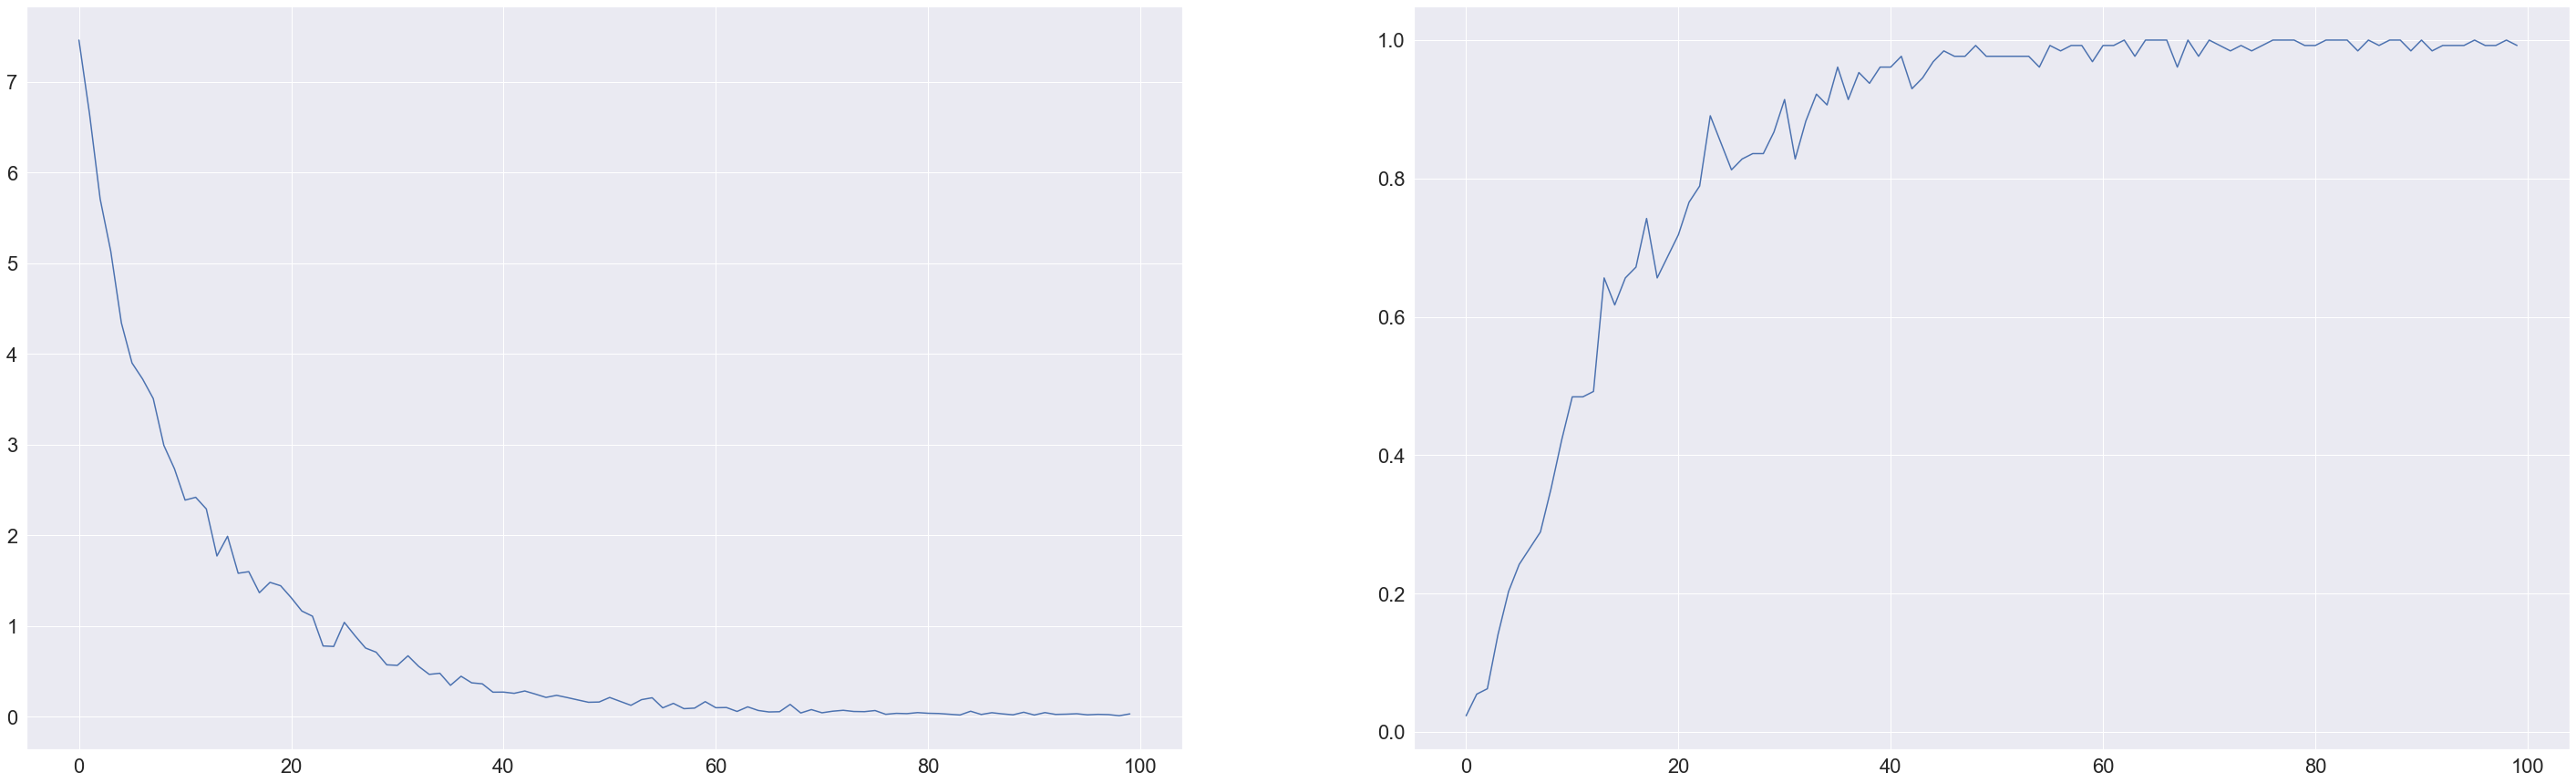

In [131]:
running_loss = []
running_acc = []

# each epoch is a complete pass over the training data
for epoch in range(100):
    # the inner loop is over the batches in the dataset
    for batch in generate_batches(frankenstein_dataset, 128, device="mps"):
        # Step 0: Get the data
        x_data = batch['x_data']
        y_target = batch['y_data']
        # Step 1: Clear the gradients        
        ep.zero_grad()
        # Step 2: Compute the forward pass of the model
        y_pred = ep(x_data, in_softmax_pass=False)
        # Step 3: Compute the loss value that we wish to optimize
        loss = ce_loss(y_pred, y_target)
        # Step 4: Propagate the loss signal backward
        loss.backward()
        # Step 5: Trigger the optimizer to perform one update
        optimizer.step()   
    acc = (
        accuracy_score(
            y_target.clone().detach().to("cpu"), 
            torch.argmax(
                y_pred.clone().detach(),
                dim=1).to("cpu")))
    running_loss.append(loss.item())
    running_acc.append(acc)
sns.set(font_scale=2)
fig, axes = plt.subplots(ncols=2, figsize=(50,15))
print("train result :")
sns.lineplot(x=range(100),y=running_loss , ax=axes[0])
sns.lineplot(x=range(100),y=running_acc , ax=axes[1])